# Project Week 6

## INEGI - Car Sales - Registro administrativo de la industria automotriz de vehículos ligeros

Monthly data per manufacturer related to the sale, production and export of new vehicle units, without specifying monetary values. For this analysis, I will focus on the sales data. 

Availability is from 2005 until 2022. For the analysis, I will use data from 2012 to 2021.


Extracted from https://www.inegi.org.mx/datosprimarios/iavl/#Datos_abiertos on May, 10th, 2022

Topics to analyze:

ANOVA analysis based on Segmento and Origen and the impact on Unidades Vendidas
Hypothesis testing of the difference of the mean of GM vs the population
Time series analysis to review the efficiency of the model

## Data importing and cleaning

In [2]:
#pip install pystan==2.19.1.1

In [3]:
#pip install prophet

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

from datetime import datetime

import itertools
from statsmodels.stats.weightstats import ztest

import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.validation import array_like

from statsmodels.formula.api import ols
from pylab import rcParams
from pandas.plotting import lag_plot

from scipy.stats import f_oneway, f
from statsmodels.stats.weightstats import ztest


In [5]:
path = 'conjunto_de_datos'
year = [i for i in range(2011, 2022)]
filenames = '/raiavl_venta_mensual_tr_cifra_{}.csv'


In [6]:
data = pd.concat(((pd.read_csv(str(path + filenames.format(str(i))))) for i in year), ignore_index=True)


In [7]:
data.head()

,PROD_EST,COBERTURA,ANIO,ID_MES,MARCA,MODELO,TIPO,SEGMENTO,ORIGEN,ID_PAIS_ORIGEN,UNI_VEH
0,Registro Administrativo de la Industria Automo...,Nacional,2011,1,Acura,Mdx,Camiones ligeros,SUV's,IMPORTADO,40,24
1,Registro Administrativo de la Industria Automo...,Nacional,2011,1,Acura,Rdx,Camiones ligeros,SUV's,IMPORTADO,66,21
2,Registro Administrativo de la Industria Automo...,Nacional,2011,1,Acura,Tl 3.5l,Automóviles,De Lujo,IMPORTADO,66,27
3,Registro Administrativo de la Industria Automo...,Nacional,2011,1,Acura,Tl 3.7l,Automóviles,De Lujo,IMPORTADO,66,5
4,Registro Administrativo de la Industria Automo...,Nacional,2011,1,Acura,TSX 2.4L,Automóviles,De Lujo,IMPORTADO,40,27


In [8]:
data.tail()

,PROD_EST,COBERTURA,ANIO,ID_MES,MARCA,MODELO,TIPO,SEGMENTO,ORIGEN,ID_PAIS_ORIGEN,UNI_VEH
50027,Registro Administrativo de la Industria Automo...,Nacional,2021,12,Volkswagen,Volkswagen Caddy,Camiones ligeros,Pick Ups,IMPORTADO,177,1
50028,Registro Administrativo de la Industria Automo...,Nacional,2021,12,Volvo,S60 III,Automóviles,De Lujo,IMPORTADO,66,20
50029,Registro Administrativo de la Industria Automo...,Nacional,2021,12,Volvo,XC40,Automóviles,De Lujo,IMPORTADO,23,87
50030,Registro Administrativo de la Industria Automo...,Nacional,2021,12,Volvo,XC60 II,Camiones ligeros,SUV's,IMPORTADO,209,141
50031,Registro Administrativo de la Industria Automo...,Nacional,2021,12,Volvo,XC90 II,Camiones ligeros,SUV's,IMPORTADO,209,74


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PROD_EST        50032 non-null  object
 1   COBERTURA       50032 non-null  object
 2   ANIO            50032 non-null  int64 
 3   ID_MES          50032 non-null  int64 
 4   MARCA           50032 non-null  object
 5   MODELO          50032 non-null  object
 6   TIPO            50032 non-null  object
 7   SEGMENTO        50032 non-null  object
 8   ORIGEN          50032 non-null  object
 9   ID_PAIS_ORIGEN  50032 non-null  int64 
 10  UNI_VEH         50032 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 4.2+ MB


In [10]:
columnas = data.columns
columns = [columna.lower() for columna in columnas]
data.columns = columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   prod_est        50032 non-null  object
 1   cobertura       50032 non-null  object
 2   anio            50032 non-null  int64 
 3   id_mes          50032 non-null  int64 
 4   marca           50032 non-null  object
 5   modelo          50032 non-null  object
 6   tipo            50032 non-null  object
 7   segmento        50032 non-null  object
 8   origen          50032 non-null  object
 9   id_pais_origen  50032 non-null  int64 
 10  uni_veh         50032 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 4.2+ MB


In [11]:
cols_to_drop = ['prod_est', 'cobertura', 'modelo']
data.drop(columns=cols_to_drop, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   anio            50032 non-null  int64 
 1   id_mes          50032 non-null  int64 
 2   marca           50032 non-null  object
 3   tipo            50032 non-null  object
 4   segmento        50032 non-null  object
 5   origen          50032 non-null  object
 6   id_pais_origen  50032 non-null  int64 
 7   uni_veh         50032 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.1+ MB


In [13]:
data.isnull().sum()

anio              0
id_mes            0
marca             0
tipo              0
segmento          0
origen            0
id_pais_origen    0
uni_veh           0
dtype: int64

In [14]:
for column in data.columns:
    print((str(column)), data[str(column)].unique())

anio [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
id_mes [ 1  2  3  4  5  6  7  8  9 10 11 12]
marca ['Acura' 'Audi' 'Bentley' 'BMW' 'Chrysler' 'Fiat' 'Ford Motor'
 'General Motors' 'Honda' 'Isuzu' 'Jaguar' 'Land Rover' 'Lincoln' 'Mazda'
 'Mercedes Benz' 'Mini' 'Mitsubishi' 'Nissan' 'Peugeot' 'Porsche'
 'Renault' 'SEAT' 'Smart' 'Subaru' 'Suzuki' 'Toyota' 'Volkswagen' 'Volvo'
 'Alfa Romeo' 'Infiniti' 'Hyundai' 'KIA' 'JAC' 'MOTORNATION' 'MG Motor'
 'Lexus']
tipo ['Camiones ligeros' 'Automóviles']
segmento ["SUV's" 'De Lujo' 'Deportivos' 'Subcompactos' 'Compactos' 'Pick Ups'
 'Minivans']
origen ['IMPORTADO' 'NACIONAL']
id_pais_origen [ 40  66   4  62  31  94 181  17  48 214   1 124 227 177  64  12  95 126
  74  46  96  23 209 169 184 200  43 999  73]
uni_veh [  24   21   27 ... 4995 2264 2006]


In [15]:
data.corr()

,anio,id_mes,id_pais_origen,uni_veh
anio,1.000000,0.010161,0.022225,-0.022320
id_mes,0.010161,1.000000,0.002957,0.028070
id_pais_origen,0.022225,0.002957,1.000000,-0.101205
uni_veh,-0.022320,0.028070,-0.101205,1.000000


In [16]:
months_num = [1,2,3,4,5,6,7,8,9,10,11,12]
months_word = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dict_months = dict(zip(months_num, months_word))
dict_months

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

In [17]:
data['mes'] = data['id_mes'].map(dict_months)
data[data['mes'] == 'Apr']['id_mes'].value_counts()

4    4117
Name: id_mes, dtype: int64

In [18]:
catalogo_pais = pd.read_csv('conjunto_de_datos/tc_pais_origen.csv')
catalogo_pais.set_index('ID_PAIS_ORIGEN', inplace=True)
dict_pais_original = catalogo_pais.to_dict('dict')
dict_pais = dict_pais_original['DESC_PAIS_ORIGEN']
dict_pais

{1: 'México',
 2: 'Afganistán',
 3: 'Albania',
 4: 'Alemania',
 5: 'Andorra',
 6: 'Angola',
 7: 'Anguila',
 8: 'Antigua y Barbuda',
 9: 'Antillas Neerlandesas',
 10: 'Arabia Saudita',
 11: 'Argelia',
 12: 'Argentina',
 13: 'Armenia',
 14: 'Aruba',
 15: 'Asia',
 16: 'Australia',
 17: 'Austria',
 18: 'Azerbaiján',
 19: 'Bahamas',
 20: 'Bahrein',
 21: 'Bangladesh',
 22: 'Barbados',
 23: 'Bélgica',
 24: 'Belice',
 25: 'Benín',
 26: 'Bermudas',
 27: 'Bielorrusia',
 28: 'Bolivia',
 29: 'Bosnia y Herzegovina',
 30: 'Botswana',
 31: 'Brasil',
 32: 'Brunei Darussalam',
 33: 'Bulgaria',
 34: 'Burkina Faso',
 35: 'Burundi',
 36: 'Bután',
 37: 'Cabo Verde',
 38: 'Camboya',
 39: 'Camerún',
 40: 'Canadá',
 41: 'Chad',
 42: 'Chile',
 43: 'China',
 44: 'Chipre',
 45: 'Ciudad del Vaticano',
 46: 'Colombia',
 47: 'Corea del Norte',
 48: 'Corea del Sur',
 49: 'Costa de Marfil',
 50: 'Costa Rica',
 51: 'Croacia',
 52: 'Cuba',
 53: 'Curazao',
 54: 'Dinamarca',
 55: 'Djibouti',
 56: 'Dominica',
 57: 'Ecuado

In [19]:
data['pais'] = data['id_pais_origen'].map(dict_pais)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50032 entries, 0 to 50031
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   anio            50032 non-null  int64 
 1   id_mes          50032 non-null  int64 
 2   marca           50032 non-null  object
 3   tipo            50032 non-null  object
 4   segmento        50032 non-null  object
 5   origen          50032 non-null  object
 6   id_pais_origen  50032 non-null  int64 
 7   uni_veh         50032 non-null  int64 
 8   mes             50032 non-null  object
 9   pais            50032 non-null  object
dtypes: int64(4), object(6)
memory usage: 3.8+ MB


In [20]:
data = data[['anio', 'id_mes', 'mes', 'marca', 'tipo', 'segmento', 'origen',
'id_pais_origen', 'pais', 'uni_veh']]

In [21]:
data.head()

,anio,id_mes,mes,marca,tipo,segmento,origen,id_pais_origen,pais,uni_veh
0,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,40,Canadá,24
1,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,66,Estados Unidos,21
2,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,27
3,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,5
4,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,40,Canadá,27


In [22]:
data.to_csv('data_clean.csv', sep=',')

## EDA

### General descriptive graphs

<AxesSubplot:xlabel='marca'>

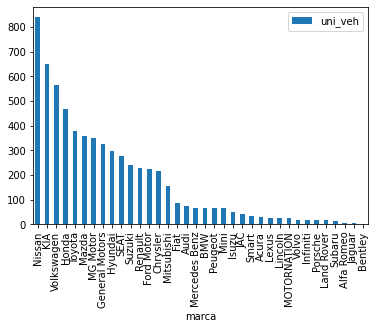

In [23]:
data.groupby('marca').agg({'uni_veh':'mean'}).sort_values('uni_veh', ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='pais'>

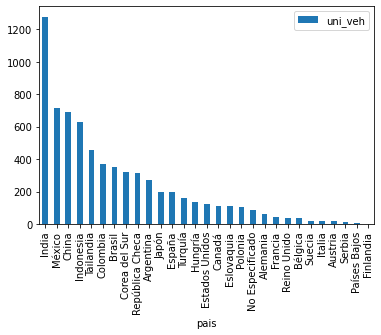

In [24]:
data.groupby('pais').agg({'uni_veh':'mean'}).sort_values('uni_veh', ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='origen'>

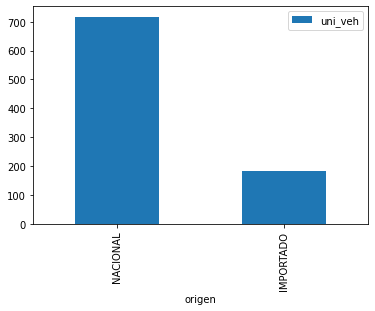

In [25]:
data.groupby('origen').agg({'uni_veh':'mean'}).sort_values('uni_veh', ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='segmento'>

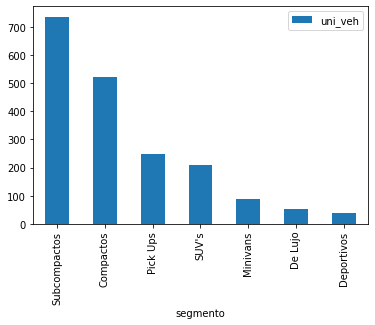

In [26]:
data.groupby('segmento').agg({'uni_veh':'mean'}).sort_values('uni_veh', ascending=False).plot(kind='bar')

<AxesSubplot:xlabel='anio'>

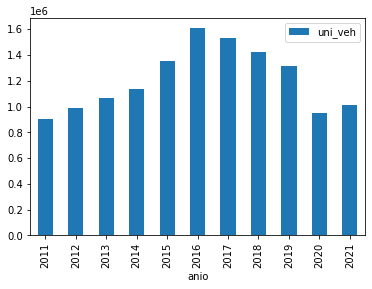

In [27]:
data.groupby('anio').agg({'uni_veh':'sum'}).sort_values('anio', ascending=True).plot(kind='bar')

### Hypothesis Testing: GM mean is according to the population mean

In [50]:
def z_score(n, x_bar, mu, sigma):
    """ Calculate z-score for a sample."""
    error_estandar = sigma / np.sqrt(n)
    estadistico_z = (x_bar - mu) / error_estandar
    return estadistico_z

In [28]:
gm = data[data['marca'] == 'General Motors']
points = gm['uni_veh']
pop_mean = data.uni_veh.mean()
pop_std = data.uni_veh.std()
pop_mean

265.877138631276

In [51]:
len(gm)

7104

In [52]:
points.mean()

326.9083614864865

In [53]:
z_score(len(gm), points.mean(), pop_mean, pop_std )

7.436650803133508

In [56]:
ztest(points, value=pop_mean) #estadístico z y p-value

(5.451039448978897, 5.0076259568691215e-08)

In [29]:
t_test, p_value = stats.ttest_1samp(points, pop_mean)
print(t_test, p_value)

5.451039448978897 5.175885720439746e-08


Yes, GM mean is outside of the population mean, we reject the null that they are the same

### Anova: Segmento y Origen sobre Unidadaes_Vendidas

In [30]:
formula = 'uni_veh ~C(segmento) + C(origen)'
model = ols(formula=formula, data=data).fit()

anova_table = sm.stats.anova_lm(model, type=2)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(segmento),6.0,2.494881e+09,4.158135e+08,1018.558619,0.0
C(origen),1.0,1.021661e+09,1.021661e+09,2502.614930,0.0
Residual,50024.0,2.042166e+10,4.082372e+05,NaN,NaN


As a conclusion, yes, both variables (segment and origin of the car) have a statistical significance and influence in the result of the sold vehicles

### Time series analysis for Full DB

In [31]:
data['anio_mes'] = pd.to_datetime({'year' : data['anio'], 'month' : data['id_mes'], 'day' : 1},  format='%m/%Y')
data.head()

,anio,id_mes,mes,marca,tipo,segmento,origen,id_pais_origen,pais,uni_veh,anio_mes
0,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,40,Canadá,24,2011-01-01
1,2011,1,Jan,Acura,Camiones ligeros,SUV's,IMPORTADO,66,Estados Unidos,21,2011-01-01
2,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,27,2011-01-01
3,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,66,Estados Unidos,5,2011-01-01
4,2011,1,Jan,Acura,Automóviles,De Lujo,IMPORTADO,40,Canadá,27,2011-01-01


In [32]:
time_full = data.groupby('anio_mes').agg({'uni_veh':'sum'})
time_full

,uni_veh
anio_mes,
2011-01-01,68767
2011-02-01,66990
2011-03-01,75125
2011-04-01,65246
2011-05-01,68634
...,...
2021-08-01,78235
2021-09-01,76930
2021-10-01,76640


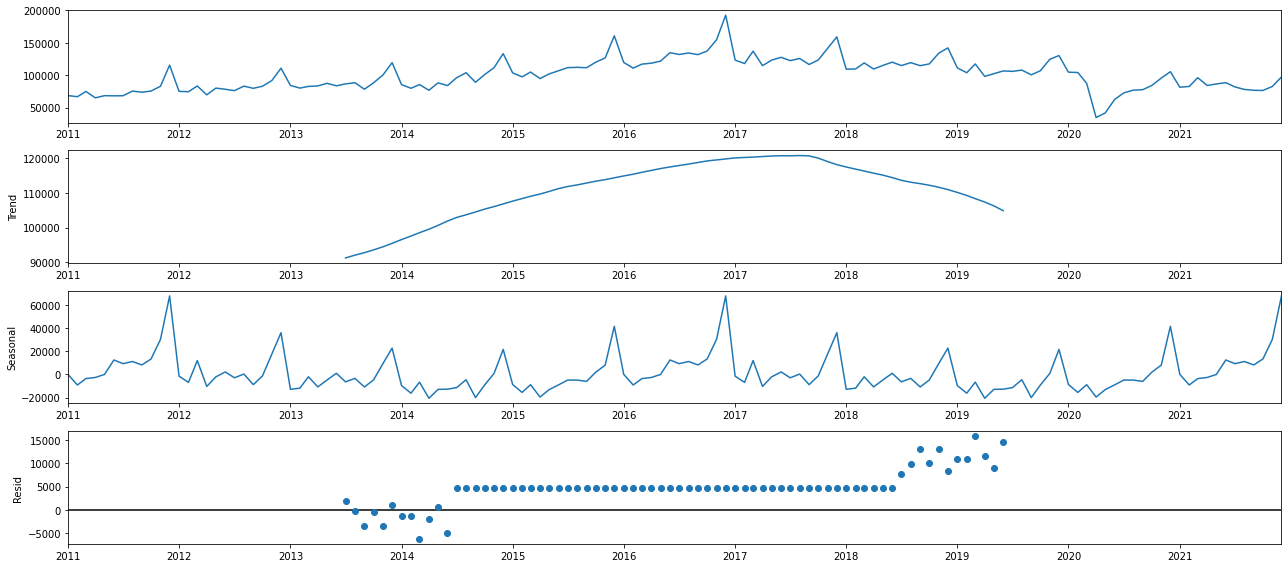

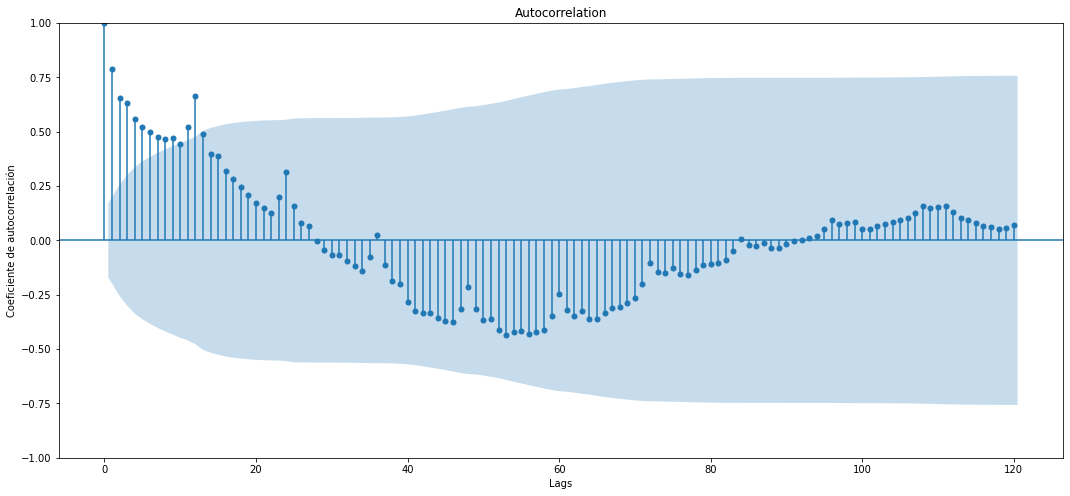

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

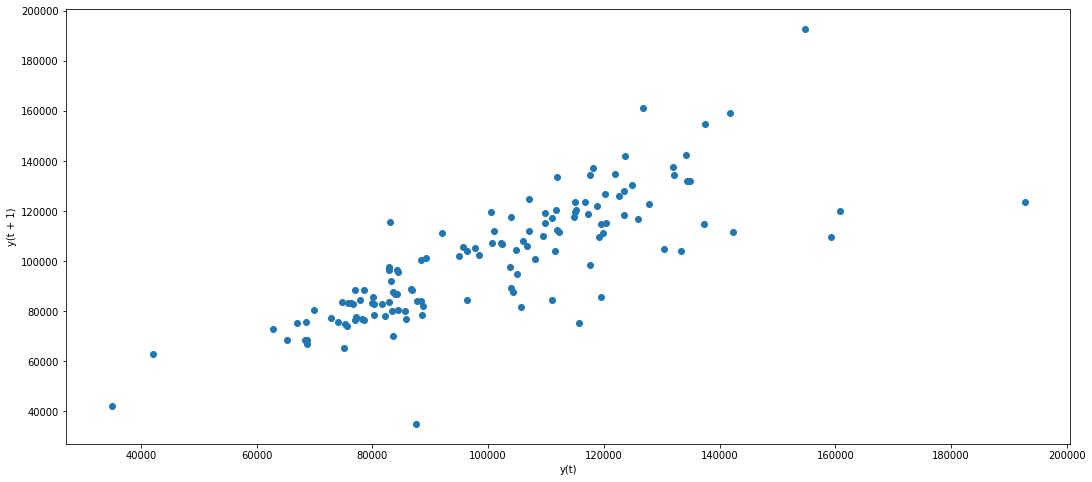

In [33]:
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(time_full, period=60)
fig = decomposition.plot()
plt.show();

tsaplots.plot_acf(time_full.values.squeeze(), lags=120)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show();

lag_plot(time_full)

In [34]:
def viewing_stationarity(df, window=5):
    """
    Esta función genera un plot para una serie de tiempo
    con su media móvil y su desviación estándar.
    """

    rolmean = df.rolling(window=window).mean()
    rolstd = df.rolling(window=window).std()

    fig = plt.figure(figsize=(10, 5))
    time_series = plt.plot(df, color='blue', label='original')
    mean = plt.plot(rolmean, color='red', label='media móvil')
    std = plt.plot(rolstd, color='green', label='desviación estándar móvil')
    plt.legend(loc='best')
    plt.show();

In [35]:
class Stationary:
    def __init__(self, significance=0.05):
        self.significance_level = significance
        self.pvalue = None
        self.is_stationary = None

    def ADF(self, values):
        result = adfuller(values, autolag='AIC')

        format_results = pd.Series(result[:4], 
                                    index=['Statistic', 'P-value',
                                        'Num of Lags', 'Observations'])
        for k,v in result[4].items():
            format_results[f'Critical Value {k}'] = v

        return format_results

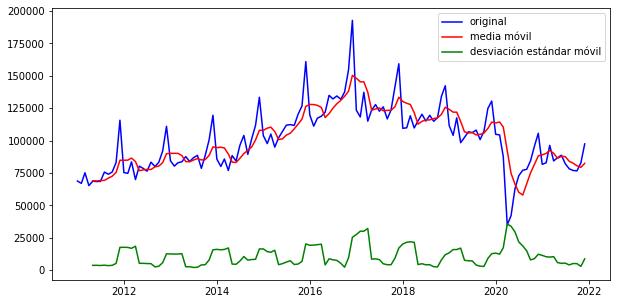

In [36]:
viewing_stationarity(time_full)

In [37]:

adf_test = Stationary()
adf_test.ADF(time_full.values).round(5)

Statistic              -1.49193
P-value                 0.53750
Num of Lags            12.00000
Observations          119.00000
Critical Value 1%      -3.48653
Critical Value 5%      -2.88615
Critical Value 10%     -2.57990
dtype: float64

Data is non-stationary, therefore, we have to make it stationary

In [38]:
time_full.head()

,uni_veh
anio_mes,
2011-01-01,68767
2011-02-01,66990
2011-03-01,75125
2011-04-01,65246
2011-05-01,68634


In [39]:
time_full_1st_der = time_full.copy()
time_full_1st_der['units_shift_1'] = time_full_1st_der['uni_veh'].shift(1)
time_full_1st_der['diff_1'] = time_full_1st_der['uni_veh'] - time_full_1st_der['units_shift_1']
time_full_1st_der.head()

,uni_veh,units_shift_1,diff_1
anio_mes,,,
2011-01-01,68767,NaN,NaN
2011-02-01,66990,68767.0,-1777.0
2011-03-01,75125,66990.0,8135.0
2011-04-01,65246,75125.0,-9879.0
2011-05-01,68634,65246.0,3388.0


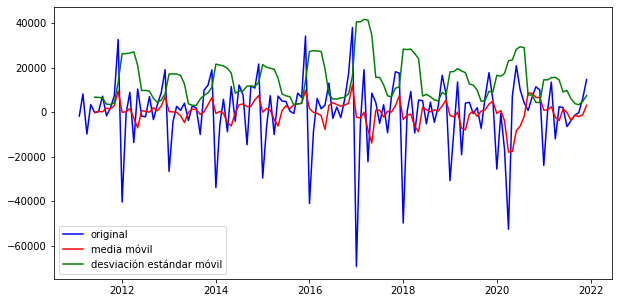

Statistic              -3.18677
P-value                 0.02076
Num of Lags            12.00000
Observations          118.00000
Critical Value 1%      -3.48702
Critical Value 5%      -2.88636
Critical Value 10%     -2.58001
dtype: float64

In [40]:
viewing_stationarity(time_full_1st_der['diff_1'])
adf_test = Stationary()
adf_test.ADF(time_full_1st_der['diff_1'].dropna().values).round(5)

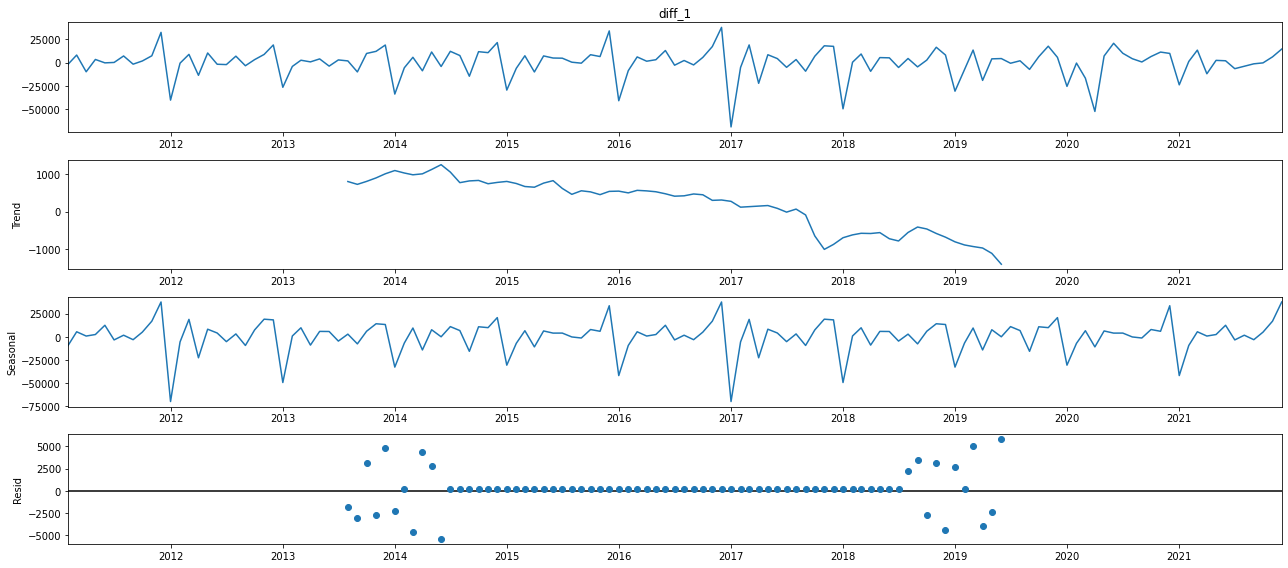

In [41]:
decomposition = sm.tsa.seasonal_decompose(time_full_1st_der['diff_1'].dropna(), period=60)
fig = decomposition.plot()
plt.show();


In [42]:
p = d = q = range(0, 3)
p, d, q

(range(0, 3), range(0, 3), range(0, 3))

In [43]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [44]:
time_full_1st_der

,uni_veh,units_shift_1,diff_1
anio_mes,,,
2011-01-01,68767,NaN,NaN
2011-02-01,66990,68767.0,-1777.0
2011-03-01,75125,66990.0,8135.0
2011-04-01,65246,75125.0,-9879.0
2011-05-01,68634,65246.0,3388.0
...,...,...,...
2021-08-01,78235,82157.0,-3922.0
2021-09-01,76930,78235.0,-1305.0
2021-10-01,76640,76930.0,-290.0


In [45]:
model = list()
aic = list()

for param in pdq:
    try:
        mod = SARIMAX(time_full_1st_der['diff_1'],
                    order=param,
                    enforce_stationarity=False)
        results = mod.fit()
        model.append(param)
        aic.append(results.aic) # Aikake Information Criterion
        print('ARIMA {} - AIC {}'.format(param, results.aic))
    except:
        print('')
        print('No pude correr el modelo')
        continue

c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\l

ARIMA (0, 0, 0) - AIC 2902.6501935821925
ARIMA (0, 0, 1) - AIC 2872.737769104383
ARIMA (0, 0, 2) - AIC 2838.83387141044
ARIMA (0, 1, 0) - AIC 2993.5261358452085
ARIMA (0, 1, 1) - AIC 2864.0678486607194
ARIMA (0, 1, 2) - AIC 2833.915106654439
ARIMA (0, 2, 0) - AIC 3110.1615013131623
ARIMA (0, 2, 1) - AIC 2954.0466522787883


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local

ARIMA (0, 2, 2) - AIC 2828.2168468818463
ARIMA (1, 0, 0) - AIC 2899.960120099099
ARIMA (1, 0, 1) - AIC 2864.3807263443728
ARIMA (1, 0, 2) - AIC 2840.5427303984134
ARIMA (1, 1, 0) - AIC 2963.676056818883
ARIMA (1, 1, 1) - AIC 2860.471464970147
ARIMA (1, 1, 2) - AIC 2846.4791749393758


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local

ARIMA (1, 2, 0) - AIC 3056.2231128069106
ARIMA (1, 2, 1) - AIC 2922.2968804507536
ARIMA (1, 2, 2) - AIC 2832.346695056684


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\l

ARIMA (2, 0, 0) - AIC 2867.205955782627
ARIMA (2, 0, 1) - AIC 2864.2890107216117
ARIMA (2, 0, 2) - AIC 2841.658341012055
ARIMA (2, 1, 0) - AIC 2901.860199992896
ARIMA (2, 1, 1) - AIC 2857.6867742304817


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\l

ARIMA (2, 1, 2) - AIC 2830.677239824712
ARIMA (2, 2, 0) - AIC 2970.1883494877097
ARIMA (2, 2, 1) - AIC 2898.9106871665126
ARIMA (2, 2, 2) - AIC 2838.0667022106927


c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [46]:
df_model = pd.DataFrame(zip(model, aic), columns=['model', 'aic'])
df_model.sort_values('aic').head()

,model,aic
8,"(0, 2, 2)",2828.216847
23,"(2, 1, 2)",2830.677240
17,"(1, 2, 2)",2832.346695
5,"(0, 1, 2)",2833.915107
26,"(2, 2, 2)",2838.066702


In [47]:
model_1st_der = SARIMAX(time_full_1st_der['diff_1'],
                    order=(0,2,2),
                    enforce_stationarity=False)
results = model_1st_der.fit()
results.summary()

c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\52551\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 diff_1   No. Observations:                  132
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1411.108
Date:                Fri, 13 May 2022   AIC                           2828.217
Time:                        16:01:07   BIC                           2836.749
Sample:                    01-01-2011   HQIC                          2831.684
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9904      0.059    -33.711      0.000      -2.106      -1.875
ma.L2          0.9997      0.061     16.303      0.000       0.880       1.120
sigma2      2.549e+08   3.43e-10   7.43e+17      0.000    2.55e+08    2.55e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.93   Jarque-Bera (JB):               143.16
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -1.56
Prob(H) (two-sided):                  0.66   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.45e+33. Standard errors may be unstable.
"""

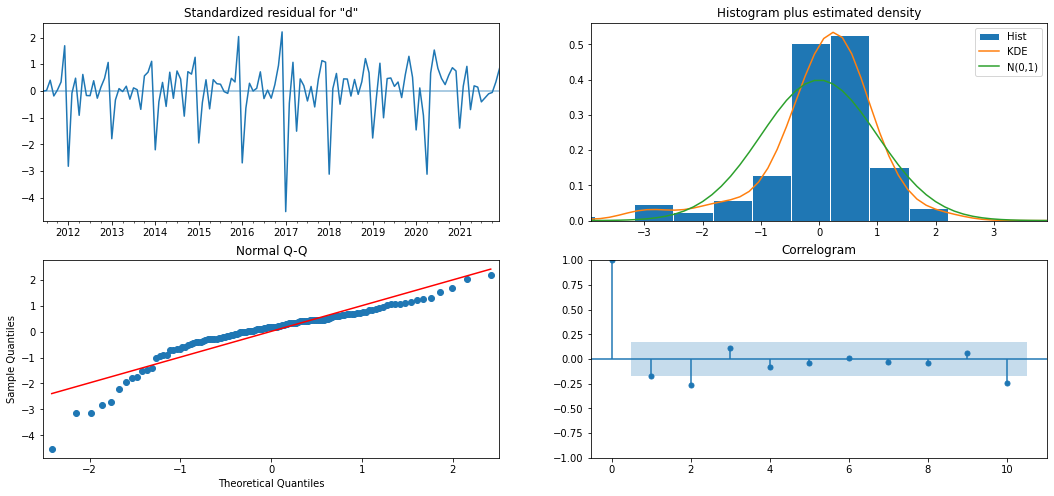

In [48]:
results.plot_diagnostics()
plt.show()

In [49]:
time_full_1st_der.to_csv('time-full-1st-der.csv', sep=',')